In [29]:
import random
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc
from torch import dtype
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from BayesianLLNN import BayesianLastLayer,TrainLastLayerCL, PredLastLayerCl, BaseNetworkCL
from baseNN import  GetNeuralNetworkClassification, TrainNNClass, PredictClass
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


Loading Dataset

In [30]:
def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

In [31]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [32]:
# load dataset, medical, diabetes, relevant. Diagnosis
df = pd.read_csv("../Data/Dataset of Diabetes .csv")
df.drop(columns=["ID","No_Pation"], inplace=True)

Pre-Processing for Input Data

In [33]:
scaler = StandardScaler()
encoder =LabelEncoder()
df["Gender"] = df["Gender"].apply(lambda x: 1 if x=="M" else 0)
c = df.columns[1:len(df.columns)-1]
df[c] =scaler.fit_transform(df[c])
df["CLASS"] = df["CLASS"].apply(lambda x: "N" if re.match(r"N",x) else "P" if x=="P" else "Y" if re.match(r"Y",x) else 0)
df["CLASS"]= pd.Categorical(df["CLASS"], categories=["N","P","Y"], ordered=True)
df["CLASS"] = encoder.fit_transform(df["CLASS"])

In [34]:
set_seed()
X = df.iloc[:,:-1].to_numpy(dtype=np.float32)
y= df['CLASS'].to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8)
tenX = torch.tensor(X_train).to(device)
tenY = torch.tensor(y_train).to(device)
tenXTest = torch.tensor(X_test).to(device)
tenYTest = torch.tensor(y_test).to(device)
tenDF = TensorDataset(tenX,tenY)

class_ids, class_counts = np.unique(y_train, return_counts=True)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(class_counts)

sample_weights = class_weights[torch.tensor(y_train)]   # shape (n_train,)
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

trainLoader = DataLoader(tenDF,batch_size=32,sampler=sampler)


Creating OOD samples


In [35]:
# Feature-Namen ohne Gender
#feature_names = df.columns[1:len(df.columns)-1]
# Wähle beliebige Werte außerhalb des Trainingsbereichs, z. B. +5 und -5 Standardabweichungen
#n_ood = 50  # wie viele OOD-Beispiele pro Feature

#ood_samples = []
#for i, feature in enumerate(feature_names):
    # Template: Mittelwert aller Features (z. B. aus X_train)
#    base = np.mean(X_train, axis=0)
    # Für dieses Feature Wert weit außerhalb setzen (+5)
#    ood_high = base.copy()
#    ood_high[i] = 8  # oder beliebig >3

#    ood_low = base.copy()
 #   ood_low[i] = -8  # oder beliebig <-3

  #  ood_samples.append(ood_high)
   # ood_samples.append(ood_low)

# Zu Array zusammenfügen
#X_ood = np.stack(ood_samples)
#X_ood = np.column_stack((np.zeros(len(X_ood)),X_ood[:,:-1]))
#y_ood = np.zeros(len(X_ood))
# Dummy, wenn Label nötig, ansonsten ignorieren
#X_test_ODD= np.vstack([X_test,X_ood])
#y_test_OOD=np.concatenate([y_test, y_ood])
# Zu Tensor (optional)
#tenX_OOD = torch.tensor(X_test_ODD, dtype=torch.float32).to(device)
#tenY_OOD = torch.tensor(y_test_OOD, dtype=torch.float32).to(device)
#MASK
#is_ood = np.array([False]*len(X_test) + [True]*len(X_ood))

In [36]:
set_seed()
base = np.mean(X_train, axis=0)  # shape: (n_feats+1,), falls die erste Spalte evtl. Label/Index war
n_ood = 100
ood_samples = []
for _ in range(n_ood):
    ood_high_all = base.copy()
    ood_high_all[:] = np.random.normal(loc=20,scale=5,size=len(ood_high_all))

    ood_samples.append(ood_high_all)

# Aus Liste ein Array machen
X_ood = np.stack(ood_samples)  # shape: (2*n_ood, n_feats+1)
X_ood_ex = 10* np.random.uniform(low=-1,high=1,size=(n_ood,X_train.shape[1]))
#scaling, for fair comparison
X_ood = np.column_stack((np.random.choice([0,5],size=n_ood), scaler.transform(X_ood_ex[:, 1:])))
y_ood = np.zeros(len(X_ood))

# Zusammensetzen mit echtem Test-Set
X_test_OOD = np.vstack([X_test, X_ood])
y_test_OOD = np.concatenate([y_test, y_ood])

tenX_OOD = torch.tensor(X_test_OOD, dtype=torch.float32).to(device)
tenY_OOD = torch.tensor(y_test_OOD, dtype=torch.float32).to(device)


is_ood = np.array([False] * len(X_test) + [True] * len(X_ood))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


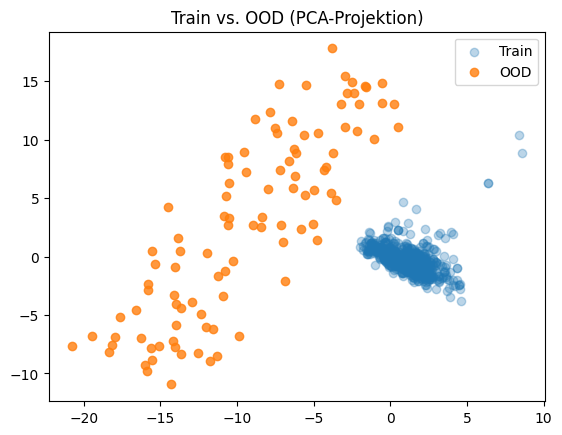

In [37]:
set_seed()
pca = PCA(n_components=2)
Z = pca.fit_transform(np.vstack([X_train, X_ood]))
plt.scatter(Z[:len(X_train), 0], Z[:len(X_train), 1], label='Train', alpha=0.3)
plt.scatter(Z[len(X_train):, 0], Z[len(X_train):, 1], label='OOD', alpha=0.8)
plt.legend(); plt.title("Train vs. OOD (PCA-Projektion)")
plt.show()

MAP Model fitting

In [38]:
# BASE NN CLASSIFIER
set_seed()
nn = GetNeuralNetworkClassification(len(df.columns[:-1]),len(np.unique(y)))
nn.load_state_dict(torch.load("../Models/basenn.pth"))
prob,mapentr = PredictClass(nn,tenX_OOD)
acm = accuracy_score(y_test_OOD,prob.argmax(axis=1))
print(f"Accuracy: {acm}")

Accuracy: 0.7966666666666666


In [39]:
# bayesian
set_seed()
base = BaseNetworkCL(len(df.columns[:-1])).to(device)
head = torch.nn.Linear(in_features=4,out_features=len(df["CLASS"].unique())).to(device)
baseMod = torch.nn.Sequential(base,head)
base.load_state_dict(torch.load("../Models/baseBayes.pth"))
# freezing base weights
for p in baseMod.parameters():
    p.requires_grad = False


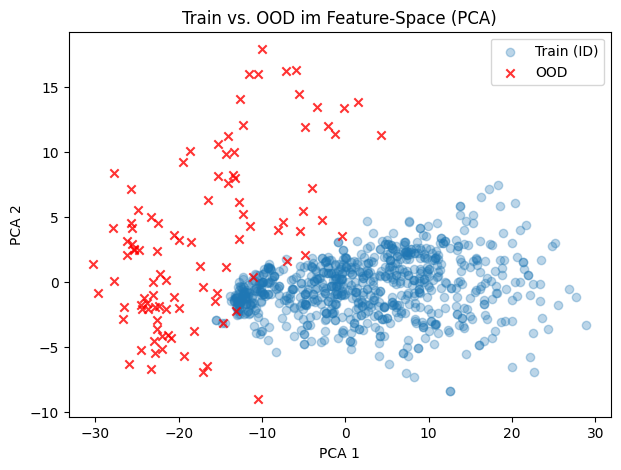

In [40]:
# Feature-Extraktion für *alle* Trainingssamples (Batchweise, falls Speicher knapp)
set_seed()
def get_features_tensor(base, X, device='mps', batchsize=32):
    feats = []
    base.eval()
    with torch.no_grad():
        for i in range(0, len(X), batchsize):
            xb = torch.tensor(X[i:i+batchsize], dtype=torch.float32, device=device)
            feats.append(base(xb).cpu().numpy())
    return np.vstack(feats)

# 1. Feature-Repräsentation für Training
feats_train = get_features_tensor(base, X_train, device=device)

# 2. Feature-Repräsentation für OOD
feats_ood = get_features_tensor(base, X_ood, device=device)

# 3. Gemeinsames Embedding via PCA
pca = PCA(n_components=2)
Z = pca.fit_transform(np.vstack([feats_train, feats_ood]))

# 4. Plot
plt.figure(figsize=(7,5))
plt.scatter(Z[:len(feats_train), 0], Z[:len(feats_train), 1], label='Train (ID)', alpha=0.3)
plt.scatter(Z[len(feats_train):, 0], Z[len(feats_train):, 1], label='OOD', alpha=0.8, color='red', marker='x')
plt.legend()
plt.title("Train vs. OOD im Feature-Space (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig("../results/OODGen.png")
plt.show()


In [41]:
#Hyperparameter grid manually defined grid because of domain knowledge
#set_seed()
#logvals_grid    = [-0.5,-0.45,-0.3,-0.25]
#prior_grid      = [0.45,0.5,0.55,0.6,1.0]
#vals = list()
#dif = list()
#best_diff  =-float('inf')
#for lv in logvals_grid:
 #   for ps in prior_grid:
      #      last = BayesianLastLayer(4, len(df["CLASS"].unique()),
  #                                   logvals=lv,
   #                                  prior_sigma=ps).to(device)
    #        TrainLastLayerCL(base=base,lastLayer= last, loader=trainLoader,class_weights=class_weights.to(device),epochs=100)
     #       mean_prob, entropy,exp_entr ,mi,energy   = PredLastLayerCl(base,last,tenX_OOD ,nSamples=100)
          #  acc = accuracy_score(y_test_OOD,mean_prob.argmax(axis=1))
       #     eid = entropy[~is_ood].mean()
        #    eood =entropy[is_ood].mean()
         #   diff = eood.mean() - eid.mean()
          #  vals.append([lv,ps])
           # dif.append(diff)

           # if diff > best_diff:
            #    best_diff = diff
             #   l,p = lv,ps
              #  torch.save(last.state_dict(), "../Models/best_lastlayer.pth")
               # with open("../Models/best_hyperparams.txt", "w") as f:
                #    f.write(f"{l},{p}")
            #print(f"lv:{lv},ps:{ps},acc:{acc}, Entropy Id:{eid}, Entropy OOD:{eood}, diff entropy: {diff}")

In [42]:
#print(l,p,best_diff)

In [43]:
set_seed()
with open("../Models/best_hyperparams.txt", "r") as f:
    l, p = map(float, f.read().strip().split(","))
lastLayer = BayesianLastLayer(in_features=4,out_features=len(df["CLASS"].unique()),logvals=l,prior_sigma=p).to(device)
lastLayer.load_state_dict(torch.load("../Models/best_lastlayer.pth"))
mean_prob, entropy,exp_entr ,mi,energy = PredLastLayerCl(base,lastLayer,tenX_OOD,nSamples=100)
#accuracy
print("wLogVar:", lastLayer.wLogVar.data.mean().item())
print("bLogVar:", lastLayer.bLogVar.data.mean().item())
print("Varianz:", torch.exp(lastLayer.wLogVar.data.mean()).item())


wLogVar: -0.768330454826355
bLogVar: -0.909104585647583
Varianz: 0.4637867212295532


In [44]:
with torch.no_grad():
    feats = base(torch.tensor(X_ood[:5], dtype=torch.float32, device=device))
    outs = [lastLayer(feats).cpu().numpy() for _ in range(100)]
    outs = np.stack(outs)  # shape: (100, 5, n_classes)
    print("Logit-Std über 100 Samples:", outs.std().mean())


Logit-Std über 100 Samples: 14.41882


In [45]:
#MAP
#ID
prob_ID = prob[~is_ood]
mapentr_ID = mapentr[~is_ood]
#OOD
prob_OOD =prob[is_ood]
mapentr_OOD = mapentr[is_ood]



#BAYES
#ID
mean_prob_ID= mean_prob[~is_ood]
pred_ent_ID = entropy[~is_ood]
aleatoric_ID = exp_entr[~is_ood]
epistemic_ID = mi[~is_ood]
energy_ID = energy[is_ood]
#OOD
mean_prob_OOD= mean_prob[is_ood]
pred_ent_OOD = entropy[is_ood]
aleatoric_OOD = exp_entr[is_ood]
epistemic_OOD = mi[is_ood]
energy_OOD = energy[~is_ood]
ac = accuracy_score(y_test_OOD,mean_prob.argmax(axis=1))
print(f"ID: entropy MAP: {mapentr_ID.mean()}, BLL{pred_ent_ID.mean()} \n OOD: entropy MAP: {mapentr_OOD.mean()}, BLL { pred_ent_OOD.mean()}, \n Accuracy: {ac}, wLogvar: {lastLayer.wLogVar.mean()}")

ID: entropy MAP: 0.06669650226831436, BLL0.28136566281318665 
 OOD: entropy MAP: 0.025795405730605125, BLL 0.5698015093803406, 
 Accuracy: 0.8166666666666667, wLogvar: -0.768330454826355


PLOTS

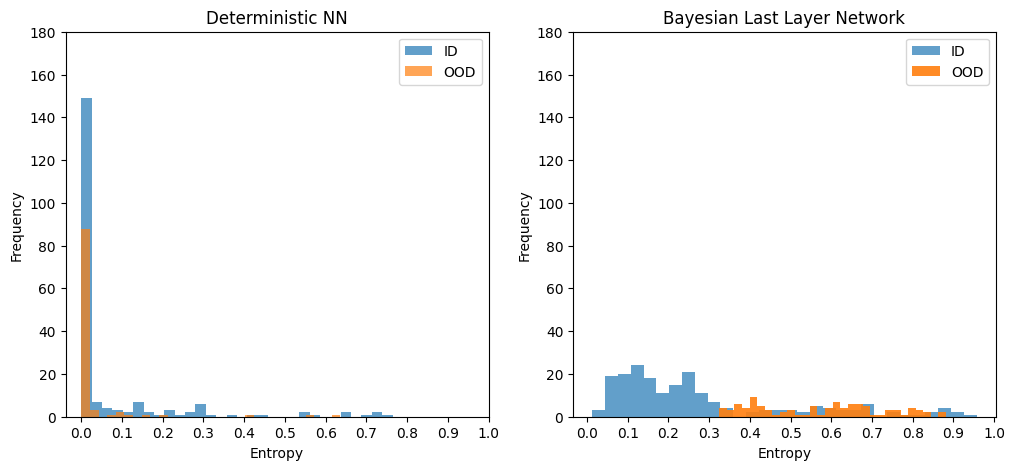

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

#MAP ENTROPY
ax1.hist(mapentr_ID, bins=30, alpha=0.7, label='ID')
ax1.hist(mapentr_OOD, bins=30, alpha=0.7, label='OOD')
ax1.set_xlabel('Entropy')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.set_yticks(np.arange(0, 200, 20))
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_title('Deterministic NN')
 #BLL ENTROPY
ax2.hist(pred_ent_ID, bins=30, alpha=0.7, label='ID')
ax2.hist(pred_ent_OOD, bins=30, alpha=0.9, label='OOD')
ax2.set_title('Bayesian Last Layer Network')
ax2.set_xlabel('Entropy')
ax2.set_ylabel('Frequency')
ax2.set_yticks(np.arange(0, 200, 20))
ax2.set_xticks(np.arange(0, 1.1, 0.1))
ax2.legend()
plt.savefig("../results/EntropyComp.png")
plt.show()

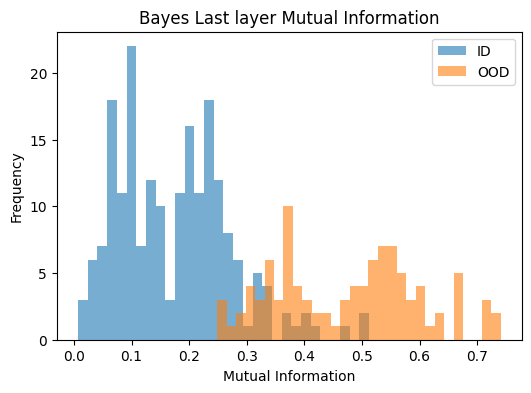

In [47]:
# Plot MI statt Entropie
plt.figure(figsize=(6,4))
plt.hist(mi[~is_ood], bins=30, alpha=0.6, label="ID")
plt.hist(mi[is_ood],  bins=30, alpha=0.6, label="OOD")
plt.title("Bayes Last layer Mutual Information")
plt.xlabel("Mutual Information")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("../results/MI.png")
plt.show()

In [48]:
#plt.hist(energy_ID, bins=30, alpha=0.7, label='ID')
#plt.hist(energy_OOD, bins=30, alpha=0.9, label='OOD')
#plt.title('Bayesian Last Layer: Energy Score')
#plt.xlabel('Energy Score')
#plt.ylabel('Häufigkeit')
#plt.legend()
#plt.show()

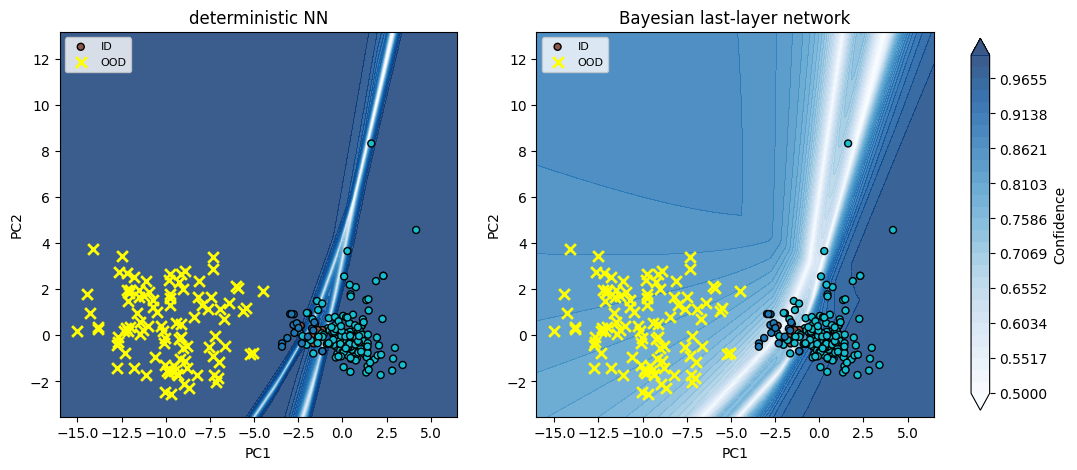

In [49]:
# 1) PCA fitten und 2D-Embeddings berechnen
set_seed()
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d  = pca.transform(X_test_OOD)

# 2) Grid-Grenzen anhand aller Punkte (Train+Test) bestimmen
all_2d = np.vstack([X_train_2d, X_test_2d])
x_min, x_max = all_2d[:,0].min() - 1, all_2d[:,0].max() + 1
y_min, y_max = all_2d[:,1].min() - 1, all_2d[:,1].max() + 1

# 3) Meshgrid erzeugen
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid_2d   = np.c_[xx.ravel(), yy.ravel()]
grid_orig = pca.inverse_transform(grid_2d)
grid_tens = torch.tensor(grid_orig, dtype=torch.float32).to(device)

# 4) Confidence berechnen
set_seed()
probs_map_all, _    = PredictClass(nn,      grid_tens)
conf_map            = probs_map_all.max(axis=1)
set_seed()
mean_prob_bll, *_   = PredLastLayerCl(base, lastLayer, grid_tens,nSamples=800)
conf_bll            = mean_prob_bll.max(axis=1)

# 5) Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor='white')
mappables = []

for ax, (label, conf) in zip(axes, [("deterministic NN", conf_map), ("Bayesian last-layer network", conf_bll)]):
    m = ax.contourf(
        xx, yy, conf.reshape(xx.shape),
        levels=np.linspace(0.5, 1.0, 30),
        cmap="Blues", alpha=0.8,
        extend='both'
    )
    mappables.append(m)
    # ID-Punkte
    mask_id = ~is_ood
    ax.scatter(
        X_test_2d[mask_id, 0],
        X_test_2d[mask_id, 1],
        c=y_test_OOD[mask_id],
        cmap="tab10",
        s=25, edgecolor="k",
        label="ID"
    )
    # OOD-Punkte
    ax.scatter(
        X_test_2d[is_ood, 0],
        X_test_2d[is_ood, 1],
        marker="x", c="yellow",
        s=60, linewidths=2,
        label="OOD"
    )
    ax.set_title(label)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(loc="upper left", fontsize=8)
    ax.set_facecolor("white")

# Gemeinsame Colorbar rechts und oberhalb aller Subplots
fig.colorbar(
    mappables[0],
    ax=axes.tolist(),
    orientation="vertical",
    fraction=0.02, pad=0.04,
    label="Confidence"
)

plt.savefig("../results/ConfidencePlot.png")
plt.show()

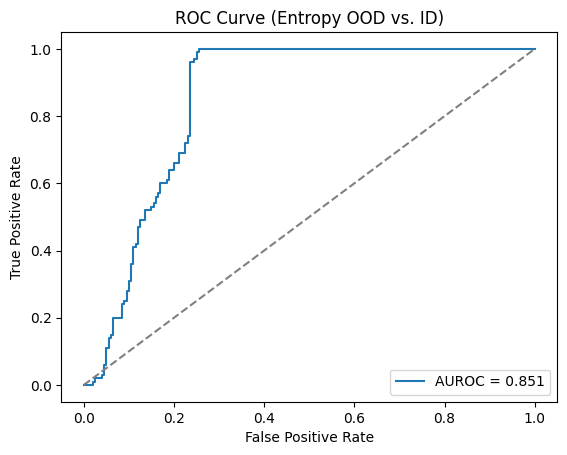

In [50]:
labels = np.concatenate([np.zeros_like(pred_ent_ID), np.ones_like(pred_ent_OOD)])
scores = np.concatenate([pred_ent_ID, pred_ent_OOD])  # oder -energy, -max_logit etc.

fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Entropy OOD vs. ID)')
plt.legend()
plt.savefig("../results/ROC.png")
plt.show()
